In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('IMDbmovies.csv')

# separate currency and amount into two new columns
df[['budget_currency','budget_amount']] = df.budget.str.split(expand=True)
df[['income_currency','income_amount']] = df.worlwide_gross_income.str.split(expand=True)
# convert amount string to numeric
df.budget_amount = pd.to_numeric(df['budget_amount'])
df.income_amount = pd.to_numeric(df['income_amount'])

df.shape

(81273, 26)

In [89]:
df.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics', 'budget_currency',
       'budget_amount', 'income_currency', 'income_amount'],
      dtype='object')

In [90]:
df['budget_currency'].unique()

array(['$', nan, 'ITL', 'ROL', 'SEK', 'FRF', 'NOK', 'GBP', 'DEM', 'PTE',
       'CAD', 'INR', 'CHF', 'FIM', 'JPY', 'DKK', 'NLG', 'PLN', 'RUR',
       'AUD', 'KRW', 'BEF', 'XAU', 'HKD', 'NZD', 'CNY', 'ESP', 'EUR',
       'PYG', 'ISK', 'IEP', 'TRL', 'HRK', 'SIT', 'PHP', 'DOP', 'JMD',
       'CZK', 'SGD', 'BRL', 'BDT', 'ATS', 'BND', 'HUF', 'EGP', 'THB',
       'GRD', 'ZAR', 'NPR', 'IDR', 'PKR', 'EEK', 'MXN', 'BGL', 'YUM',
       'MYR', 'IRR', 'CLP', 'SKK', 'LTL', 'TWD', 'MTL', 'LVL', 'COP',
       'ARS', 'UAH', 'NGN', 'ILS', 'VEB', 'VND', 'TTD', 'LKR', 'GEL',
       'RON', 'MNT', 'AZM', 'ALL', 'AMD', 'AED'], dtype=object)

In [91]:
df.groupby('budget_currency')['budget_currency'].agg('count')

budget_currency
$      16148
AED        2
ALL        1
AMD        1
ARS       14
       ...  
VEB        2
VND        3
XAU        1
YUM        2
ZAR       18
Name: budget_currency, Length: 78, dtype: int64

In [97]:
movies_american = df[df['budget_currency'] == '$']

In [98]:
movies_less_columns = movies_american.drop(['budget','budget_currency','income_currency','usa_gross_income','worlwide_gross_income','reviews_from_users','language','reviews_from_users','original_title','usa_gross_income','date_published','writer','production_company','imdb_title_id'], axis='columns')

movies_clean = movies_less_columns.dropna()

In [99]:
movies_clean.isnull().sum()

title                   0
year                    0
genre                   0
duration                0
country                 0
director                0
actors                  0
description             0
avg_vote                0
votes                   0
metascore               0
reviews_from_critics    0
budget_amount           0
income_amount           0
dtype: int64

In [100]:
movies_clean

,title,year,genre,duration,country,director,actors,description,avg_vote,votes,metascore,reviews_from_critics,budget_amount,income_amount
604,The Circus,1928,"Comedy, Romance",72,USA,Charles Chaplin,"Al Ernest Garcia, Merna Kennedy, Harry Crocker...",The Tramp finds work and the girl of his dream...,8.2,23629,90.0,61.0,900000.0,26916.0
1005,City Lights,1931,"Comedy, Drama, Romance",87,USA,Charles Chaplin,"Virginia Cherrill, Florence Lee, Harry Myers, ...","With the aid of a wealthy erratic tippler, a d...",8.5,152716,99.0,120.0,1500000.0,32609.0
1242,Freaks,1932,"Drama, Horror",64,USA,Tod Browning,"Wallace Ford, Leila Hyams, Olga Baclanova, Ros...",A circus' beautiful trapeze artist agrees to m...,7.9,39346,80.0,149.0,310607.0,4072.0
1527,King Kong,1933,"Adventure, Horror, Sci-Fi",100,USA,"Merian C. Cooper, Ernest B. Schoedsack","Fay Wray, Robert Armstrong, Bruce Cabot, Frank...",A film crew goes to a tropical island for an e...,7.9,75049,90.0,159.0,670000.0,651.0
2336,Modern Times,1936,"Comedy, Drama, Family",87,USA,Charles Chaplin,"Charles Chaplin, Paulette Goddard, Henry Bergm...",The Tramp struggles to live in modern industri...,8.5,197969,96.0,146.0,1500000.0,445226.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80665,Midsommar,2019,"Drama, Horror, Mystery",147,"USA, Sweden, Hungary",Ari Aster,"Florence Pugh, Jack Reynor, Vilhelm Blomgren, ...",A couple travels to Sweden to visit a rural ho...,7.2,78830,72.0,365.0,10000000.0,41123770.0
80858,Unplanned,2019,"Biography, Drama",109,USA,"Chuck Konzelman, Cary Solomon","Ashley Bratcher, Brooks Ryan, Robia Scott, Jar...",All Abby Johnson ever wanted to do was help wo...,5.8,10783,10.0,32.0,6000000.0,19320481.0
80908,Cold Blood Legacy,2019,"Action, Thriller",91,"France, Ukraine, Belgium",Frédéric Petitjean,"Jean Reno, Sarah Lind, Joe Anderson, David Gya...",A hit-man lives isolated in a cabin at the edg...,4.5,2193,25.0,26.0,2700000.0,1009888.0
80946,Playing with Fire,2019,"Comedy, Family",96,USA,Andy Fickman,"John Cena, Keegan-Michael Key, John Leguizamo,...",A crew of rugged firefighters meet their match...,4.5,1067,24.0,16.0,29900000.0,21788746.0


In [103]:
movies_clean.director.value_counts()

Clint Eastwood                   34
Woody Allen                      32
Steven Spielberg                 31
Steven Soderbergh                26
Martin Scorsese                  24
                                 ..
Debra Granik                      1
Daniel Benmayor                   1
John Lasseter, Ash Brannon        1
Duke Johnson, Charlie Kaufman     1
Louis Leterrier, Corey Yuen       1
Name: director, Length: 2767, dtype: int64

In [104]:
movies_clean['director']

604                             Charles Chaplin
1005                            Charles Chaplin
1242                               Tod Browning
1527     Merian C. Cooper, Ernest B. Schoedsack
2336                            Charles Chaplin
                          ...                  
80665                                 Ari Aster
80858             Chuck Konzelman, Cary Solomon
80908                        Frédéric Petitjean
80946                              Andy Fickman
81059                    Jon Lucas, Scott Moore
Name: director, Length: 6190, dtype: object

In [102]:
movies_clean.director.value_counts()

Clint Eastwood                   34
Woody Allen                      32
Steven Spielberg                 31
Steven Soderbergh                26
Martin Scorsese                  24
                                 ..
Debra Granik                      1
Daniel Benmayor                   1
John Lasseter, Ash Brannon        1
Duke Johnson, Charlie Kaufman     1
Louis Leterrier, Corey Yuen       1
Name: director, Length: 2767, dtype: int64

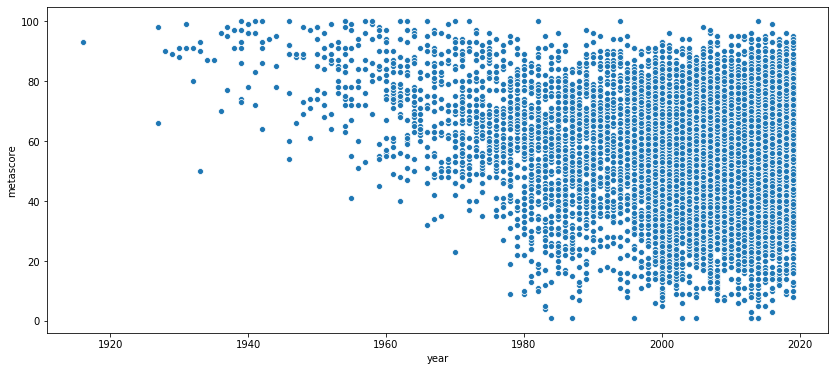

In [10]:
fig, ax = plt.subplots(figsize=(14,6))
# sns.lineplot(x=df.year, y=df.income_amount, data=df)
# sns.lineplot(x=df.year, y=df.budget_amount, data=df)
sns.scatterplot(x=modern_movies.year, y=modern_movies.metascore)

In [11]:
clinteastwoodfilms = df[df.director == "Clint Eastwood"]

NameError: name 'df' is not defined

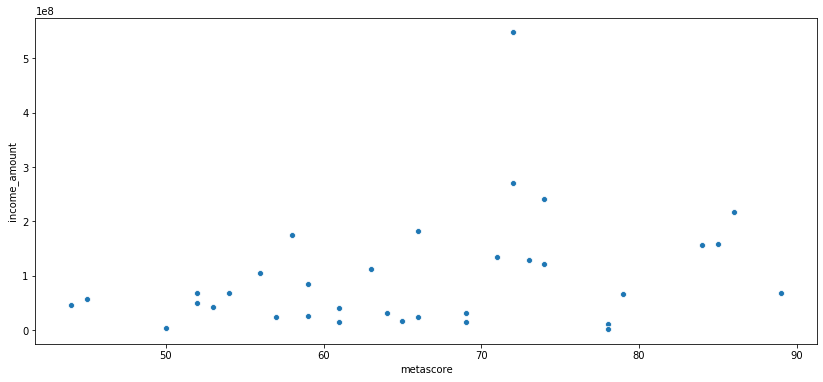

In [42]:
fig, ax = plt.subplots(figsize=(14,6))
sns.scatterplot(x=clinteastwoodfilms.metascore, y=clinteastwoodfilms.income_amount, data=clinteastwoodfilms)

In [30]:
movies.genre.unique()

for i in movies.genre
    genres = genre.split(',')
    return genres

array(['Comedy, Drama, Romance', 'Comedy, Drama, Family',
       'Animation, Family, Fantasy', 'Drama, History, Romance',
       'Comedy, Drama', 'Adventure, Family, Fantasy',
       'Animation, Comedy, Family', 'Drama, Mystery',
       'Drama, Romance, War', 'Comedy, Fantasy, Romance',
       'Adventure, Drama, Western', 'Drama', 'Crime, Drama, Mystery',
       'Comedy, Musical, Romance', 'Drama, Family',
       'Animation, Adventure, Family', 'Drama, War', 'Crime, Thriller',
       'Drama, Horror, Sci-Fi', 'Mystery, Thriller',
       'Drama, Musical, Romance', 'Animation, Adventure, Comedy',
       'Drama, Western', 'Adventure, Drama, War',
       'Crime, Drama, Film-Noir', 'Mystery, Romance, Thriller',
       'Adventure, Drama, History', 'War, Drama',
       'Horror, Mystery, Thriller', 'Adventure, Biography, Drama',
       'Adventure, Family', 'Crime, Drama, Musical',
       'Action, Adventure, Thriller', 'Western', 'Drama, Thriller',
       'Crime, Drama', 'Biography, Drama, Histo

In [31]:
movies.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics', 'budget_currency',
       'budget_amount', 'income_currency', 'income_amount'],
      dtype='object')

In [37]:
movies.drop(['original_title', 'production_company'], axis=1)

,imdb_title_id,title,year,date_published,genre,duration,country,language,director,writer,...,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,budget_currency,budget_amount,income_currency,income_amount
1005,tt0021749,City Lights,1931,1931-08-21,"Comedy, Drama, Romance",87,USA,English,Charles Chaplin,Charles Chaplin,...,$ 1500000,$ 19181,$ 32609,99.0,270.0,120.0,$,1500000.0,$,32609.0
2336,tt0027977,Modern Times,1936,1936-10-16,"Comedy, Drama, Family",87,USA,English,Charles Chaplin,Charles Chaplin,...,$ 1500000,$ 163577,$ 445226,96.0,262.0,146.0,$,1500000.0,$,445226.0
2687,tt0029583,Snow White and the Seven Dwarfs,1937,1938-07-08,"Animation, Family, Fantasy",83,USA,English,"William Cottrell, David Hand","Jacob Grimm, Wilhelm Grimm",...,$ 1499000,$ 184925486,$ 184925486,95.0,229.0,166.0,$,1499000.0,$,184925486.0
3100,tt0031381,Gone with the Wind,1939,1942-09-04,"Drama, History, Romance",238,USA,English,"Victor Fleming, George Cukor","Margaret Mitchell, Sidney Howard",...,$ 3977000,$ 200852579,$ 402352579,97.0,808.0,183.0,$,3977000.0,$,402352579.0
3180,tt0031679,Mr. Smith Goes to Washington,1939,1940-05-03,"Comedy, Drama",129,USA,English,Frank Capra,"Sidney Buchman, Lewis R. Foster",...,$ 1900000,$ 144738,$ 144738,73.0,272.0,110.0,$,1900000.0,$,144738.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80665,tt8772262,Midsommar,2019,2019-07-03,"Drama, Horror, Mystery",147,"USA, Sweden, Hungary","English, Swedish",Ari Aster,Ari Aster,...,$ 10000000,$ 27426361,$ 41123770,72.0,1454.0,365.0,$,10000000.0,$,41123770.0
80858,tt9024106,Unplanned,2019,2019-10-04,"Biography, Drama",109,USA,English,"Chuck Konzelman, Cary Solomon","Abby Johnson, Chuck Konzelman",...,$ 6000000,$ 19005109,$ 19320481,10.0,531.0,32.0,$,6000000.0,$,19320481.0
80908,tt9082020,Cold Blood Legacy,2019,2019-05-15,"Action, Thriller",91,"France, Ukraine, Belgium","French, English",Frédéric Petitjean,Frédéric Petitjean,...,$ 2700000,$ 5083,$ 1009888,25.0,72.0,26.0,$,2700000.0,$,1009888.0
80946,tt9134216,Playing with Fire,2019,2019-11-08,"Comedy, Family",96,USA,English,Andy Fickman,"Dan Ewen, Matt Lieberman",...,$ 29900000,$ 18847824,$ 21788746,24.0,49.0,16.0,$,29900000.0,$,21788746.0


In [43]:
movies.director

1005                   Charles Chaplin
2336                   Charles Chaplin
2687      William Cottrell, David Hand
3100      Victor Fleming, George Cukor
3180                       Frank Capra
                     ...              
80665                        Ari Aster
80858    Chuck Konzelman, Cary Solomon
80908               Frédéric Petitjean
80946                     Andy Fickman
81059           Jon Lucas, Scott Moore
Name: director, Length: 5909, dtype: object